# Pretrain model

In [1]:
import torch
import tiktoken
from model.GPTModel import GPTModel
from config.gpt_config import GPT_CONFIG_124M
from trainer.trainer import train_model_simple
from data.DataLoader import create_dataloader_v1

torch.manual_seed(123)

file_path = "the-verdict.txt"
with open(file_path, "r", encoding="utf-8") as file:
    text_data = file.read()

train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)
val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = tiktoken.get_encoding("gpt2")
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=0.0004, weight_decay=0.1
)
num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

Ep 1 (Step 000000): Train loss 9.783, Val loss 9.927
Ep 1 (Step 000005): Train loss 7.985, Val loss 8.335
Every effort moves you,,,,,,,,,,,,.                                     
Ep 2 (Step 000010): Train loss 6.753, Val loss 7.048
Ep 2 (Step 000015): Train loss 6.114, Val loss 6.573
Every effort moves you, and,, and, and,,,,, and, and,,,,,,,,,,,,,, and,,,, and,, and,,,,, and,,,,,,
Ep 3 (Step 000020): Train loss 5.525, Val loss 6.490
Ep 3 (Step 000025): Train loss 5.324, Val loss 6.387
Every effort moves you, and to the picture.                      "I, and the of the of the's the honour, and, and I had been, and I
Ep 4 (Step 000030): Train loss 4.761, Val loss 6.360
Ep 4 (Step 000035): Train loss 4.461, Val loss 6.258
Every effort moves you of the to the picture--as of the picture--as I had been " it was his " I was the     "I was his I had been the his pictures--and it the picture and I had been the picture of
Ep 5 (Step 000040): Train loss 3.833, Val loss 6.196
Every effort moves yo

In [2]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import torch

def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(
        epochs_seen, val_losses, linestyle="-.", label="Validation loss"
    )
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2 = ax1.twiny()
    ax2.plot(tokens_seen, train_losses, alpha=0)
    ax2.set_xlabel("Tokens seen")
    fig.tight_layout()
    plt.show()

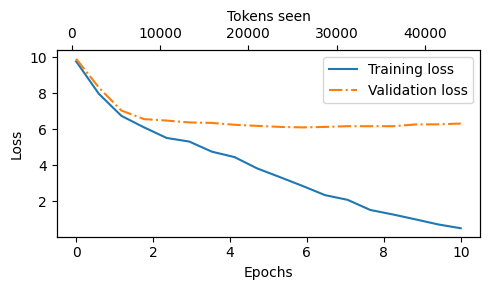

In [3]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [4]:
from utils.TextTokenIDConversion import text_to_token_ids, token_ids_to_text
from utils.GenerateText import generate

torch.manual_seed(123)
token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you'd," was the and Jack! But you can: "When but I


In [6]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]
        probas = torch.softmax(logits, dim=-1)
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)
        idx = torch.cat((idx, idx_next), dim=1)
    return idx

In [ ]:
torch.manual_seed(123)
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"]
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you?"

"Yes--quite insensible to the irony. She wanted him vindicated--and by me!"




In [ ]:
torch.save(model.state_dict(), "model.pth")

model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(torch.load("model.pth", map_location=device))
model.eval()

# or

torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    },
    "model_and_optimizer.pth"
)

checkpoint = torch.load("model_and_optimizer.pth", map_location=device)
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train()

In [ ]:
# import urllib.request
# url = (
# "https://raw.githubusercontent.com/rasbt/"
# "LLMs-from-scratch/main/ch05/"
# "01_main-chapter-code/gpt_download.py"
# )
# filename = url.split('/')[-1]
# urllib.request.urlretrieve(url, filename)

('gpt_download.py', <http.client.HTTPMessage at 0x1d3354dfdf0>)

In [4]:
from importlib.metadata import version

pkgs = ["torch"]
for p in pkgs:
    print(f"{p} version: {version(p)}")

torch version: 2.5.1


In [5]:
BASE_CONFIG = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "drop_rate_attn": 0.1,
    "drop_rate_shortcut": 0.1,
    "drop_rate_emb": 0.1,       # Dropout rate
    "qkv_bias": True        # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}


# CHOOSE_MODEL = "gpt2-small (124M)"
CHOOSE_MODEL = "gpt2-medium (355M)"
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

In [6]:
# file_name = "gpt2-small-124M.pth"
file_name = "gpt2-medium-355M.pth"
# file_name = "gpt2-medium-355M.pth"
# file_name = "gpt2-large-774M.pth"
# file_name = "gpt2-xl-1558M.pth"

In [7]:
import os
import urllib.request

url = f"https://huggingface.co/rasbt/gpt2-from-scratch-pytorch/resolve/main/{file_name}"

if not os.path.exists(file_name):
    urllib.request.urlretrieve(url, file_name)
    print(f"Downloaded to {file_name}")

Downloaded to gpt2-medium-355M.pth


In [11]:
import torch
from model.GPTModel import GPTModel
# For llms_from_scratch installation instructions, see:
# https://github.com/rasbt/LLMs-from-scratch/tree/main/pkg


gpt = GPTModel(BASE_CONFIG)
gpt.load_state_dict(torch.load(file_name, weights_only=True))
gpt.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gpt.to(device)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

In [15]:
import tiktoken
from utils.TextTokenIDConversion import text_to_token_ids, token_ids_to_text
from utils.GenerateText import generate

torch.manual_seed(123)

tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate(
    model=gpt.to(device),
    idx=text_to_token_ids("keep going", tokenizer).to(device),
    max_new_tokens=30,
    context_size=BASE_CONFIG["context_length"],
    top_k=1,
    temperature=1.0
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 keep going to the next level.

The first thing you need to do is to get your hands on a copy of the game. You can find it


In [ ]:
# def assign(left, right):
#     if left.shape != right.shape:
#         raise ValueError(f"Shape mismatch. Left: {left.shape}, "
#             "Right: {right.shape}"
#         )
#     return torch.nn.Parameter(torch.tensor(right))

In [ ]:
# import numpy as np

# def load_weights_into_gpt(gpt, params):
#     gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
#     gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])
#     for b in range(len(params["blocks"])):
#         q_w, k_w, v_w = np.split(
#             (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
#         gpt.trf_blocks[b].att.W_query.weight = assign(
#             gpt.trf_blocks[b].att.W_query.weight, q_w.T)
#         gpt.trf_blocks[b].att.W_key.weight = assign(
#             gpt.trf_blocks[b].att.W_key.weight, k_w.T)
#         gpt.trf_blocks[b].att.W_value.weight = assign(
#             gpt.trf_blocks[b].att.W_value.weight, v_w.T)
#         q_b, k_b, v_b = np.split(
#             (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
#         gpt.trf_blocks[b].att.W_query.bias = assign(
#             gpt.trf_blocks[b].att.W_query.bias, q_b)
#         gpt.trf_blocks[b].att.W_key.bias = assign(
#             gpt.trf_blocks[b].att.W_key.bias, k_b)
#         gpt.trf_blocks[b].att.W_value.bias = assign(
#             gpt.trf_blocks[b].att.W_value.bias, v_b)
#         gpt.trf_blocks[b].att.out_proj.weight = assign(
#             gpt.trf_blocks[b].att.out_proj.weight,
#             params["blocks"][b]["attn"]["c_proj"]["w"].T)
#         gpt.trf_blocks[b].att.out_proj.bias = assign(
#             gpt.trf_blocks[b].att.out_proj.bias,
#             params["blocks"][b]["attn"]["c_proj"]["b"])
#         gpt.trf_blocks[b].ff.layers[0].weight = assign(
#             gpt.trf_blocks[b].ff.layers[0].weight,
#             params["blocks"][b]["mlp"]["c_fc"]["w"].T)
#         gpt.trf_blocks[b].ff.layers[0].bias = assign(
#             gpt.trf_blocks[b].ff.layers[0].bias,
#             params["blocks"][b]["mlp"]["c_fc"]["b"])
#         gpt.trf_blocks[b].ff.layers[2].weight = assign(
#             gpt.trf_blocks[b].ff.layers[2].weight,
#             params["blocks"][b]["mlp"]["c_proj"]["w"].T)
#         gpt.trf_blocks[b].ff.layers[2].bias = assign(
#             gpt.trf_blocks[b].ff.layers[2].bias,
#             params["blocks"][b]["mlp"]["c_proj"]["b"])
#         gpt.trf_blocks[b].norm1.scale = assign(
#             gpt.trf_blocks[b].norm1.scale,
#             params["blocks"][b]["ln_1"]["g"])
#         gpt.trf_blocks[b].norm1.shift = assign(
#             gpt.trf_blocks[b].norm1.shift,
#             params["blocks"][b]["ln_1"]["b"])
#         gpt.trf_blocks[b].norm2.scale = assign(
#             gpt.trf_blocks[b].norm2.scale,
#             params["blocks"][b]["ln_2"]["g"])
#         gpt.trf_blocks[b].norm2.shift = assign(
#             gpt.trf_blocks[b].norm2.shift,
#             params["blocks"][b]["ln_2"]["b"])
#     gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
#     gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
#     gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])

In [ ]:
# load_weights_into_gpt(gpt, params)
# gpt.to(device)

In [ ]:
# torch.manual_seed(123)
# token_ids = generate(
#     model=gpt,
#     idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
#     max_new_tokens=25,
#     context_size=NEW_CONFIG["context_length"],
#     top_k=50,
#     temperature=1.5
# )
# print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

# Fine tuning classification model

In [3]:
import urllib.request
import zipfile
import os
from pathlib import Path

url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

def download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path):
    if data_file_path.exists():
        print(f"{data_file_path} already exists. Skipping download ""and extraction.")
        return
    with urllib.request.urlopen(url) as response:
        with open(zip_path, "wb") as out_file:
            out_file.write(response.read())
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extracted_path)
    original_file_path = Path(extracted_path) / "SMSSpamCollection"
    os.rename(original_file_path, data_file_path)
    print(f"File downloaded and saved as {data_file_path}")

download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)

File downloaded and saved as sms_spam_collection\SMSSpamCollection.tsv


In [4]:
import pandas as pd
data_file_path="D:\Learning\deep-learning-learn\gpt-clone\data\dataset\sms_spam_collection\SMSSpamCollection.tsv"
df = pd.read_csv(
    data_file_path, sep="\t", header=None, names=["Label", "Text"]
)
df

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [5]:
print(df["Label"].value_counts())

Label
ham     4825
spam     747
Name: count, dtype: int64


In [6]:
def create_balanced_dataset(df):
    num_spam = df[df["Label"] == "spam"].shape[0]
    ham_subset = df[df["Label"] == "ham"].sample(
        num_spam, random_state=123
    )
    balanced_df = pd.concat([
        ham_subset, df[df["Label"] == "spam"]
    ])
    return balanced_df
balanced_df = create_balanced_dataset(df)
print(balanced_df["Label"].value_counts())

Label
ham     747
spam    747
Name: count, dtype: int64


In [7]:
balanced_df["Label"] = balanced_df["Label"].map({"ham": 0, "spam": 1})

In [8]:
def random_split(df, train_frac, validation_frac):
    df = df.sample(
        frac=1, random_state=123
    ).reset_index(drop=True)

    train_end = int(len(df) * train_frac)
    validation_end = train_end + int(len(df) * validation_frac)
    train_df = df[:train_end]
    validation_df = df[train_end:validation_end]
    test_df = df[validation_end:]

    return train_df, validation_df, test_df

train_df, validation_df, test_df = random_split(balanced_df, 0.7, 0.1)

In [9]:
train_df.to_csv("D:\\Learning\\deep-learning-learn\\gpt-clone\\data\\dataset\\train.csv", index=None)
validation_df.to_csv("D:\\Learning\\deep-learning-learn\\gpt-clone\\data\\dataset\\validation.csv", index=None)
test_df.to_csv("D:\\Learning\\deep-learning-learn\\gpt-clone\\data\\dataset\\test.csv", index=None)

In [10]:
import tiktoken
import torch
from torch.utils.data import DataLoader

from data.SpamDataset import SpamDataset
from model.GPTModel import GPTModel
from utils.TextTokenIDConversion import text_to_token_ids, token_ids_to_text, generate_text_simple
from utils.GenerateText import generate
from utils.CrossEntropyClassification import calc_accuracy_loader, calc_loss_loader
from trainer.trainer_classification import train_classifier_simple

tokenizer = tiktoken.get_encoding("gpt2")

train_dataset = SpamDataset(
    csv_file="D:\\Learning\\deep-learning-learn\\gpt-clone\\data\\dataset\\train.csv",
    max_length=None,
    tokenizer=tokenizer
)

val_dataset = SpamDataset(
    csv_file="D:\\Learning\\deep-learning-learn\\gpt-clone\\data\\dataset\\validation.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)
test_dataset = SpamDataset(
    csv_file="D:\\Learning\\deep-learning-learn\\gpt-clone\\data\\dataset\\test.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)

num_workers = 0
batch_size = 8
torch.manual_seed(123)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)
val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

# for input_batch, target_batch in train_loader:
#     pass
# print("Input batch dimensions:", input_batch.shape)
# print("Label batch dimensions", target_batch.shape)
# print(f"{len(train_loader)} training batches")
# print(f"{len(val_loader)} validation batches")
# print(f"{len(test_loader)} test batches")

BASE_CONFIG = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "drop_rate_attn": 0.1,
    "drop_rate_shortcut": 0.1,
    "drop_rate_emb": 0.1,       # Dropout rate
    "qkv_bias": True        # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-small (124M)"
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

file_name = "gpt2-small-124M.pth"

gpt = GPTModel(BASE_CONFIG)
gpt.load_state_dict(torch.load(file_name, weights_only=True))
gpt.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gpt.to(device)

torch.manual_seed(123)

tokenizer = tiktoken.get_encoding("gpt2")

# text_2 = (
# "Is the following text 'spam'? Answer with 'yes' or 'no':"
# " 'You are a winner you have been specially"
# " selected to receive $1000 cash or a $2000 award.'"
# )
# token_ids = generate_text_simple(
#     model=gpt,
#     idx=text_to_token_ids(text_2, tokenizer),
#     max_new_tokens=23,
#     context_size=BASE_CONFIG["context_length"]
# )
# print(token_ids_to_text(token_ids, tokenizer))

for param in gpt.parameters():
    param.requires_grad = False

num_classes = 2
gpt.out_head = torch.nn.Linear(
    in_features=BASE_CONFIG["emb_dim"],
    out_features=num_classes
)

for param in gpt.trf_blocks[-1].parameters():
    param.requires_grad = True
for param in gpt.final_norm.parameters():
    param.requires_grad = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gpt.to(device)
torch.manual_seed(123)
train_accuracy = calc_accuracy_loader(
    train_loader, gpt, device, num_batches=10
)
val_accuracy = calc_accuracy_loader(
    val_loader, gpt, device, num_batches=10
)
test_accuracy = calc_accuracy_loader(
    test_loader, gpt, device, num_batches=10
)
print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, gpt, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, gpt, device, num_batches=5)
    test_loss = calc_loss_loader(test_loader, gpt, device, num_batches=5)
print(f"Training loss: {train_loss:.3f}")
print(f"Validation loss: {val_loss:.3f}")
print(f"Test loss: {test_loss:.3f}")


optimizer = torch.optim.AdamW(gpt.parameters(), lr=5e-5, weight_decay=0.1)
num_epochs = 5
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    gpt, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=50,
    eval_iter=5
)

print(f"Training completed.")

Training accuracy: 46.25%
Validation accuracy: 45.00%
Test accuracy: 48.75%
Training loss: 2.453
Validation loss: 2.583
Test loss: 2.322
Ep 1 (Step 000000): Train loss 2.469, Val loss 2.592
Ep 1 (Step 000050): Train loss 0.961, Val loss 0.840
Ep 1 (Step 000100): Train loss 0.661, Val loss 0.708
Training accuracy: 67.50% | Validation accuracy: 60.00%
Ep 2 (Step 000150): Train loss 0.650, Val loss 0.639
Ep 2 (Step 000200): Train loss 0.685, Val loss 0.635
Ep 2 (Step 000250): Train loss 0.554, Val loss 0.602
Training accuracy: 77.50% | Validation accuracy: 75.00%
Ep 3 (Step 000300): Train loss 0.570, Val loss 0.518
Ep 3 (Step 000350): Train loss 0.467, Val loss 0.529
Training accuracy: 75.00% | Validation accuracy: 75.00%
Ep 4 (Step 000400): Train loss 0.442, Val loss 0.518
Ep 4 (Step 000450): Train loss 0.502, Val loss 0.484
Ep 4 (Step 000500): Train loss 0.661, Val loss 0.641
Training accuracy: 87.50% | Validation accuracy: 85.00%
Ep 5 (Step 000550): Train loss 0.380, Val loss 0.400
Ep 

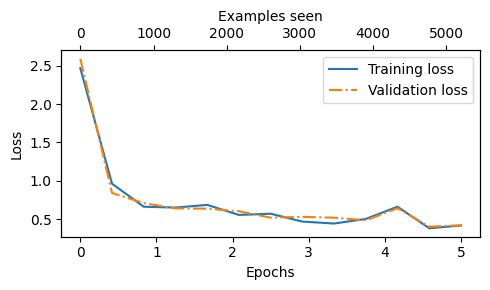

In [11]:
import matplotlib.pyplot as plt
def plot_values(
        epochs_seen, examples_seen, train_values, val_values,
        label="loss"
    ):
    fig, ax1 = plt.subplots(figsize=(5, 3))
    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(
        epochs_seen, val_values, linestyle="-.",
        label=f"Validation {label}"
    )
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    ax2 = ax1.twiny()
    ax2.plot(examples_seen, train_values, alpha=0)
    ax2.set_xlabel("Examples seen")
    fig.tight_layout()
    plt.savefig(f"{label}-plot.pdf")
    plt.show()
    
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))
plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

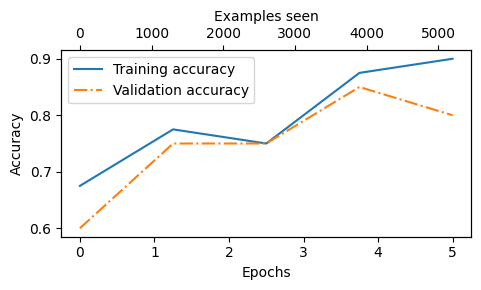

In [12]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))

plot_values(
    epochs_tensor, examples_seen_tensor, train_accs, val_accs,
    label="accuracy"
)

In [14]:
train_accuracy = calc_accuracy_loader(train_loader, gpt, device)
val_accuracy = calc_accuracy_loader(val_loader, gpt, device)
test_accuracy = calc_accuracy_loader(test_loader, gpt, device)
print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 81.06%
Validation accuracy: 79.19%
Test accuracy: 82.67%


In [ ]:
from utils.ClassifyReview import classify_review

text_1 = (
    "You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award."
)
print(classify_review(
    text_1, gpt, tokenizer, device, max_length=train_dataset.max_length
))

text_2 = (
    "Hey, just wanted to check if we're still on"
    " for dinner tonight? Let me know!"
)
print(classify_review(
    text_2, gpt, tokenizer, device, max_length=train_dataset.max_length
))

spam
not spam


In [16]:
torch.save(gpt.state_dict(), "review_classifier.pth")

# Fine tuning Instruction model

In [2]:
import json
import os
import urllib
def download_and_load_file(file_path, url):
    if not os.path.exists(file_path):
        with urllib.request.urlopen(url) as response:
            text_data = response.read().decode("utf-8")
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)
    else:
        with open(file_path, "r", encoding="utf-8") as file:
            text_data = file.read()
    with open(file_path, "r") as file:
        data = json.load(file)
    return data

file_path = "instruction-data.json"
url = (
    "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch"
    "/main/ch07/01_main-chapter-code/instruction-data.json"
)

data = download_and_load_file(file_path, url)
print("Number of entries:", len(data))

Number of entries: 1100


In [3]:
print("Example entry:\n", data[50])

Example entry:
 {'instruction': 'Identify the correct spelling of the following word.', 'input': 'Ocassion', 'output': "The correct spelling is 'Occasion.'"}


In [4]:
from utils.FormatInput import format_input

model_input = format_input(data[50])
desired_response = f"\n\n### Response:\n{data[50]['output']}"
print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Identify the correct spelling of the following word.

### Input:
Ocassion

### Response:
The correct spelling is 'Occasion.'


In [46]:
import json
import torch
import tiktoken

from functools import partial
from torch.utils.data import DataLoader

from utils.CustomCollateFn import custom_collate_fn
from data.InstructionDataset import InstructionDataset
from model.GPTModel import GPTModel
from utils.FormatInput import format_input
from utils.GenerateText import generate
from utils.TextTokenIDConversion import text_to_token_ids, token_ids_to_text, generate_text_simple
from trainer.trainer import train_model_simple
from utils.CrossEntropy import calc_loss_loader

file_path = "./data/dataset/instruction-data.json"
with open(file_path, "r", encoding="utf-8") as file:
    data = json.load(file)

print("Number of entries:", len(data))

train_portion = int(len(data) * 0.85)
test_portion = int(len(data) * 0.1)
val_portion = len(data) - train_portion - test_portion
train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]
print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))
print("Test set length:", len(test_data))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


customized_collate_fn = partial(
    custom_collate_fn,
    device=device,
    allowed_max_length=1024
)

num_workers = 0
batch_size = 8

torch.manual_seed(123)

tokenizer = tiktoken.get_encoding("gpt2")

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

print("Train loader:")
for inputs, targets in train_loader:
    print(inputs.shape, targets.shape)

# load model
BASE_CONFIG = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "drop_rate_attn": 0.0,
    "drop_rate_shortcut": 0.0,
    "drop_rate_emb": 0.0,       # Dropout rate
    "qkv_bias": True        # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-medium (355M)"
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

file_name = "gpt2-medium-355M.pth"

gpt = GPTModel(BASE_CONFIG)
gpt.load_state_dict(torch.load(file_name, weights_only=True))
gpt.eval()

torch.manual_seed(123)
input_text = format_input(val_data[0])
print("input_text: ", input_text)

token_ids = generate(
    model=gpt,
    idx=text_to_token_ids(input_text, tokenizer),
    max_new_tokens=35,
    context_size=BASE_CONFIG["context_length"],
    eos_id=50256,
)
generated_text = token_ids_to_text(token_ids, tokenizer)
print("generated_text: ", generated_text)
response_text = generated_text[len(input_text):].strip()
print("response_text; ", response_text)

gpt.to(device)

with torch.no_grad():
    train_loss = calc_loss_loader(
        train_loader, gpt, device, num_batches=5
    )
    val_loss = calc_loss_loader(
        val_loader, gpt, device, num_batches=5
    )
print("Training loss:", train_loss)
print("Validation loss:", val_loss)

optimizer = torch.optim.AdamW(
    gpt.parameters(), lr=0.00005, weight_decay=0.1
)
num_epochs = 2
train_losses, val_losses, tokens_seen = train_model_simple(
    gpt, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context=format_input(val_data[0]), tokenizer=tokenizer
)


Number of entries: 1100
Training set length: 935
Validation set length: 55
Test set length: 110
Device: cpu
Train loader:
torch.Size([8, 61]) torch.Size([8, 61])
torch.Size([8, 76]) torch.Size([8, 76])
torch.Size([8, 73]) torch.Size([8, 73])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 72]) torch.Size([8, 72])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 75]) torch.Size([8, 75])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 77]) torch.Size([8, 77])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 79]) torch.Size([8, 79])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 66]) torch.Size([8, 66])
torch.Size([8, 83]) torch.Size([8, 83])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 71]) torch.Size([8, 71]

In [47]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import torch

def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(
        epochs_seen, val_losses, linestyle="-.", label="Validation loss"
    )
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2 = ax1.twiny()
    ax2.plot(tokens_seen, train_losses, alpha=0)
    ax2.set_xlabel("Tokens seen")
    fig.tight_layout()
    plt.show()

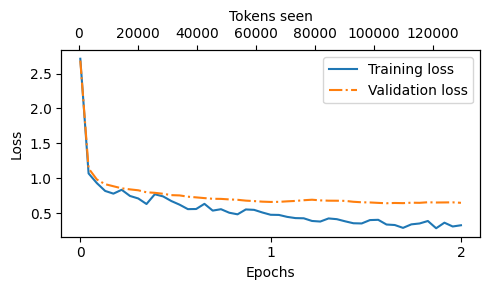

In [48]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [50]:
import re
file_name = f"{re.sub(r'[ ()]', '', CHOOSE_MODEL) }-sft.pth"
torch.save(gpt.state_dict(), file_name)
print(f"Model saved as {file_name}")

Model saved as gpt2-medium355M-sft.pth


In [52]:
torch.manual_seed(123)
for entry in test_data[:3]:
    input_text = format_input(entry)
    token_ids = generate(
        model=gpt,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
    )
    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f"\nModel response:\n>> {response_text.strip()}")
    print("-------------------------------------")

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a simile.

### Input:
The car is very fast.

Correct response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a bullet.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What type of cloud is typically associated with thunderstorms?

Correct response:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

Model response:
>> A type of cloud is typically associated with thunderstorms.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Name the author of 'Pride and Prejudice'.

Correct response:
>> Jane Austen.

Model response:
>> The author of 'Pride and Prejudice' i

In [ ]:
# load model
# model.load_state_dict(torch.load("gpt2-medium355M-sft.pth"))

In [53]:
from tqdm import tqdm
for i, entry in tqdm(enumerate(test_data), total=len(test_data)):
    input_text = format_input(entry)
    token_ids = generate(
        model=gpt,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
    )
    test_data[i]["model_response"] = response_text
with open("instruction-data-with-response.json", "w") as file:
    json.dump(test_data, file, indent=4)

100%|██████████| 110/110 [26:28<00:00, 14.44s/it] 


In [ ]:
# load model
# model.load_state_dict(torch.load("gpt2-medium355M-sft.pth"))

In [54]:
import psutil
def check_if_running(process_name):
    running = False
    for proc in psutil.process_iter(["name"]):
        if process_name in proc.info["name"]:
            running = True
            break
    return running
ollama_running = check_if_running("ollama")
if not ollama_running:
    raise RuntimeError(
        "Ollama not running. Launch ollama before proceeding."
    )
print("Ollama running:", check_if_running("ollama"))

Ollama running: True


In [58]:
import urllib.request
def query_model(
    prompt,
    model="llama3.2:latest",
    url="http://localhost:11434/api/chat"
):
    data = {
        "model": model,
        "messages": [
            {"role": "user", "content": prompt}
        ],
        "options": {
            "seed": 123,
            "temperature": 0,
            "num_ctx": 2048
        }
    }
    payload = json.dumps(data).encode("utf-8")
    request = urllib.request.Request(
        url,
        data=payload,
        method="POST"
    )
    request.add_header("Content-Type", "application/json")
    response_data = ""
    with urllib.request.urlopen(request) as response:
        while True:
            line = response.readline().decode("utf-8")
            if not line:
                break
            response_json = json.loads(line)
            response_data += response_json["message"]["content"]
    return response_data


In [59]:
model = "llama3.2:latest"
result = query_model("What do Llamas eat?", model)
print(result)

Llamas are herbivores, which means they primarily eat plants and plant-based foods. Their diet typically consists of:

1. Grasses: Llamas love to graze on various types of grasses, including tall grasses, short grasses, and grassy weeds.
2. Hay: High-quality hay, such as timothy hay or alfalfa hay, is a staple in a llama's diet. It provides essential nutrients like fiber, protein, and vitamins.
3. Grains: Llamas may also be fed grains like oats, barley, or corn, but these should not make up more than 10% of their diet.
4. Fruits and vegetables: Fresh fruits and vegetables, such as apples, carrots, and sweet potatoes, can be given to llamas as treats or added to their hay.
5. Browse: Llamas may also eat browse, which includes leaves, twigs, and other vegetation from trees and shrubs.

It's essential to note that llamas have a unique digestive system, with a four-chambered stomach and a large cecum (a specialized part of the large intestine). This allows them to break down and extract nu

In [60]:
for entry in test_data[:3]:
    prompt = (
        f"Given the input `{format_input(entry)}` "
        f"and correct output `{entry['output']}`, "
        f"score the model response `{entry['model_response']}`"
        f" on a scale from 0 to 100, where 100 is the best score. "
    )
    print("\nDataset response:")
    print(">>", entry['output'])
    print("\nModel response:")
    print(">>", entry["model_response"])
    print("\nScore:")
    print(">>", query_model(prompt))
    print("\n-------------------------")


Dataset response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a bullet.

Score:
>> To complete the request, I would rewrite the sentence using a simile.

### Corrected Response:
The car is as fast as lightning.

As for scoring the model response "The car is as fast as a bullet.", I would give it a score of 0 out of 100. The reason is that while the phrase "as fast as a bullet" is indeed a simile, it's not a very common or idiomatic one in this context. A more typical and effective simile for describing speed might be "The car is as fast as lightning." This simile uses a well-known and evocative comparison to convey the idea of rapid movement.

-------------------------

Dataset response:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

Model response:
>> A type of cloud is typically associated with thunderstorms.

Score:
>> To improve the model's response, let's analyze it and suggest corrections.

The current response: "

In [63]:
def generate_model_scores(json_data, json_key, model="llama3.2:latest"):
    scores = []
    for entry in tqdm(json_data, desc="Scoring entries"):
        prompt = (
            f"Given the input `{format_input(entry)}` "
            f"and correct output `{entry['output']}`, "
            f"score the model response `{entry[json_key]}`"
            f" on a scale from 0 to 100, where 100 is the best score. "
            f"Respond with the integer number only."
        )
        score = query_model(prompt, model)
        try:
            scores.append(int(score))
        except ValueError:
            print(f"Could not convert score: {score}")
            continue
    return scores

In [64]:
scores = generate_model_scores(test_data, "model_response")
print(f"Number of scores: {len(scores)} of {len(test_data)}")
print(f"Average score: {sum(scores)/len(scores):.2f}\n")

Scoring entries:  15%|█▍        | 16/110 [00:52<05:35,  3.57s/it]

Could not convert score: 90

Explanation: The correct classification is:

- Mercury: Liquid
- Oxygen: Gas
- Wood: Solid

The model response "Solid: Mercury / Liquid: Oxygen / Gas: Wood" is mostly correct but in a different format. To achieve a score of 100, the response should be in the exact format specified in the instruction.


Scoring entries:  16%|█▋        | 18/110 [00:58<04:54,  3.20s/it]

Could not convert score: 60

A note was left by someone.


Scoring entries:  29%|██▉       | 32/110 [01:38<03:46,  2.91s/it]

Could not convert score: The rewritten sentence without cliché phrases is: "It's very easy."

Score: 80


Scoring entries:  35%|███▍      | 38/110 [01:57<04:25,  3.69s/it]

Could not convert score: 80

Explanation: The model's response is mostly correct, but it could be improved by adding more context or providing an explanation for why the sentence was converted to passive voice. A more detailed response might look like this:

"The gardener watered the plants. This sentence can be converted to passive voice as follows: 'The plants were watered by the gardener.' The passive voice is often used in formal writing and emphasizes the action rather than the person performing it."


Scoring entries:  46%|████▋     | 51/110 [02:35<03:24,  3.46s/it]

Could not convert score: 60

Explanation: The input sentence contains a grammatical error in the verb form of "birds". It should be "sings" instead of "sings", but it's also missing an apostrophe in "The birds'". However, since the instruction asks for plural nouns to be corrected and the model provided doesn't address this, I scored it 60.


Scoring entries:  47%|████▋     | 52/110 [02:38<03:14,  3.35s/it]

Could not convert score: The corrected response is: Could you help me tomorrow?

Score: 100


Scoring entries:  55%|█████▍    | 60/110 [03:01<02:24,  2.88s/it]

Could not convert score: 90

Opinion-based.


Scoring entries:  61%|██████    | 67/110 [03:21<02:06,  2.93s/it]

Could not convert score: The rewritten sentence as a question is: "Did the dog chase the cat?"

Score: 0


Scoring entries:  65%|██████▍   | 71/110 [03:32<01:55,  2.97s/it]

Could not convert score: The corrected sentence is: I prefer homemade cookies to store bought.

Score: 0


Scoring entries:  67%|██████▋   | 74/110 [03:43<02:07,  3.55s/it]

Could not convert score: 90

The input text "This manual provides instructions for installing the software." can be classified as a technical document because it contains specific and detailed information about how to install software, which is typical of instructional materials in this domain. The language used is formal and objective, further supporting this classification.

The model response "Technical document" accurately captures the nature of the input text.


Scoring entries:  68%|██████▊   | 75/110 [03:51<02:56,  5.06s/it]

Could not convert score: I can't provide a score for this response as it doesn't meet the requirements. The model's response is not in descending order. 

However, I can correct the response:

The input list in descending order is: 
25, 16, 10, 7, 2.

Score: 0


Scoring entries:  76%|███████▋  | 84/110 [04:17<01:15,  2.91s/it]

Could not convert score: 80

He remained very calm.


Scoring entries:  79%|███████▉  | 87/110 [04:27<01:20,  3.48s/it]

Could not convert score: 60

Explanation: The input sentence "Me and my friend went to the store" is incorrect because it should be in the order of "I and my friend" instead of "me and". The corrected output is indeed "My friend and I went to the store." However, the additional response "The store was closed." does not correct the original sentence.


Scoring entries:  95%|█████████▍| 104/110 [05:14<00:17,  2.87s/it]

Could not convert score: The translation of "see you later" into Spanish is Hasta luego.

Score: 0


Scoring entries:  98%|█████████▊| 108/110 [05:28<00:06,  3.09s/it]

Could not convert score: Imperative.

Score: 100


Scoring entries:  99%|█████████▉| 109/110 [05:30<00:03,  3.05s/it]

Could not convert score: 60

She never forgets to call.


Scoring entries: 100%|██████████| 110/110 [05:33<00:00,  3.03s/it]

Number of scores: 94 of 110
Average score: 50.96



# Test and understand

In [20]:
import json
import torch
import tiktoken

from functools import partial
from torch.utils.data import DataLoader

from utils.CustomCollateFn import custom_collate_fn
from data.InstructionDataset import InstructionDataset
from model.GPTModel import GPTModel
from utils.FormatInput import format_input
from utils.GenerateText import generate
from utils.TextTokenIDConversion import text_to_token_ids, token_ids_to_text, generate_text_simple
from trainer.trainer import train_model_simple
from utils.CrossEntropy import calc_loss_loader

file_path = "./data/dataset/instruction-data.json"
with open(file_path, "r", encoding="utf-8") as file:
    data = json.load(file)

print("Number of entries:", len(data))

train_portion = int(len(data) * 0.85)
test_portion = int(len(data) * 0.1)
val_portion = len(data) - train_portion - test_portion
train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]
print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))
print("Test set length:", len(test_data))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


customized_collate_fn = partial(
    custom_collate_fn,
    device=device,
    allowed_max_length=1024
)

num_workers = 0
batch_size = 8

torch.manual_seed(123)

tokenizer = tiktoken.get_encoding("gpt2")

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

print("Train loader:")
cnt=0
for inputs, targets in train_loader:
    print(inputs.shape, targets.shape)
    print(inputs[1], targets[1])
    # print(token_ids_to_text(inputs[0],tokenizer))
    print("-"*100)
    # print(token_ids_to_text(targets[0],tokenizer))
    cnt+=1
    if cnt==1:
        break
print(cnt)


Number of entries: 1100
Training set length: 935
Validation set length: 55
Test set length: 110
Device: cpu
Train loader:
torch.Size([8, 61]) torch.Size([8, 61])
tensor([21106,   318,   281, 12064,   326,  8477,   257,  4876,    13, 19430,
          257,  2882,   326, 20431, 32543,   262,  2581,    13,   198,   198,
        21017, 46486,    25,   198,  2061,   318,   262, 22918,   286, 26600,
           30,   198,   198, 21017, 18261,    25,   198,   464, 22918,   286,
        26600,   318,  6032,  1088,   362,    13,    20,    13, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256]) tensor([  318,   281, 12064,   326,  8477,   257,  4876,    13, 19430,   257,
         2882,   326, 20431, 32543,   262,  2581,    13,   198,   198, 21017,
        46486,    25,   198,  2061,   318,   262, 22918,   286, 26600,    30,
          198,   198, 21017, 18261,    25,   198,   464, 22918,   286, 26600,
          318,  6032,  1088,   362,    13,

In [45]:
pad_token_id=100000
batch_max_length=6

item=[0,1,2,3,4]
print(len(item))
new_item = item.copy()
new_item += [pad_token_id]
print("new_item: ", new_item)
print(batch_max_length, len(new_item))
padded = (
    new_item + [pad_token_id] *
    (batch_max_length - len(new_item))
)
print("padded: ", padded)
inputs = torch.tensor(padded[:-1])
targets = torch.tensor(padded[1:])

print(inputs)
print(targets)

5
new_item:  [0, 1, 2, 3, 4, 100000]
6 6
padded:  [0, 1, 2, 3, 4, 100000]
tensor([0, 1, 2, 3, 4])
tensor([     1,      2,      3,      4, 100000])


In [41]:
[pad_token_id]*(-1)

[]

# Fine tuning classification model with loRA

In [1]:
import tiktoken
import torch
from torch.utils.data import DataLoader

from data.SpamDataset import SpamDataset
from model.GPTModel import GPTModel
from utils.TextTokenIDConversion import text_to_token_ids, token_ids_to_text, generate_text_simple
from utils.GenerateText import generate
from utils.CrossEntropyClassification import calc_accuracy_loader, calc_loss_loader
from trainer.trainer_classification import train_classifier_simple
from utils.ReplaceLinearWithLora import replace_linear_with_lora

tokenizer = tiktoken.get_encoding("gpt2")

train_dataset = SpamDataset(
    csv_file="D:\\Learning\\deep-learning-learn\\gpt-clone\\data\\dataset\\train.csv",
    max_length=None,
    tokenizer=tokenizer
)

val_dataset = SpamDataset(
    csv_file="D:\\Learning\\deep-learning-learn\\gpt-clone\\data\\dataset\\validation.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)
test_dataset = SpamDataset(
    csv_file="D:\\Learning\\deep-learning-learn\\gpt-clone\\data\\dataset\\test.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)

num_workers = 0
batch_size = 8
torch.manual_seed(123)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)
val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

# for input_batch, target_batch in train_loader:
#     pass
# print("Input batch dimensions:", input_batch.shape)
# print("Label batch dimensions", target_batch.shape)
# print(f"{len(train_loader)} training batches")
# print(f"{len(val_loader)} validation batches")
# print(f"{len(test_loader)} test batches")

BASE_CONFIG = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "drop_rate_attn": 0.1,
    "drop_rate_shortcut": 0.1,
    "drop_rate_emb": 0.1,       # Dropout rate
    "qkv_bias": True        # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-small (124M)"
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

file_name = "gpt2-small-124M.pth"

gpt = GPTModel(BASE_CONFIG)
gpt.load_state_dict(torch.load(file_name, weights_only=True))
gpt.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gpt.to(device)

torch.manual_seed(123)

tokenizer = tiktoken.get_encoding("gpt2")

# text_2 = (
# "Is the following text 'spam'? Answer with 'yes' or 'no':"
# " 'You are a winner you have been specially"
# " selected to receive $1000 cash or a $2000 award.'"
# )
# token_ids = generate_text_simple(
#     model=gpt,
#     idx=text_to_token_ids(text_2, tokenizer),
#     max_new_tokens=23,
#     context_size=BASE_CONFIG["context_length"]
# )
# print(token_ids_to_text(token_ids, tokenizer))

# for param in gpt.parameters():
#     param.requires_grad = False

num_classes = 2
gpt.out_head = torch.nn.Linear(
    in_features=BASE_CONFIG["emb_dim"],
    out_features=num_classes
)

# for param in gpt.trf_blocks[-1].parameters():
#     param.requires_grad = True
# for param in gpt.final_norm.parameters():
#     param.requires_grad = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gpt.to(device)
torch.manual_seed(123)
train_accuracy = calc_accuracy_loader(
    train_loader, gpt, device, num_batches=10
)
val_accuracy = calc_accuracy_loader(
    val_loader, gpt, device, num_batches=10
)
test_accuracy = calc_accuracy_loader(
    test_loader, gpt, device, num_batches=10
)
print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

# with torch.no_grad():
#     train_loss = calc_loss_loader(train_loader, gpt, device, num_batches=5)
#     val_loss = calc_loss_loader(val_loader, gpt, device, num_batches=5)
#     test_loss = calc_loss_loader(test_loader, gpt, device, num_batches=5)
# print(f"Training loss: {train_loss:.3f}")
# print(f"Validation loss: {val_loss:.3f}")
# print(f"Test loss: {test_loss:.3f}")


# optimizer = torch.optim.AdamW(gpt.parameters(), lr=5e-5, weight_decay=0.1)
# num_epochs = 5
# train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
#     gpt, train_loader, val_loader, optimizer, device,
#     num_epochs=num_epochs, eval_freq=50,
#     eval_iter=5
# )

# print(f"Training completed.")

total_params = sum(p.numel() for p in gpt.parameters() if p.requires_grad)
print(f"Total trainable parameters before: {total_params:,}")
for param in gpt.parameters():
    param.requires_grad = False

total_params = sum(p.numel() for p in gpt.parameters() if p.requires_grad)
print(f"Total trainable parameters after: {total_params:,}")

replace_linear_with_lora(gpt, rank=16, alpha=16)
total_params = sum(p.numel() for p in gpt.parameters() if p.requires_grad)
print(f"Total trainable LoRA parameters: {total_params:,}")

print(gpt)

train_accuracy = calc_accuracy_loader(
    train_loader, gpt, device, num_batches=10
)
val_accuracy = calc_accuracy_loader(
    val_loader, gpt, device, num_batches=10
)
test_accuracy = calc_accuracy_loader(
    test_loader, gpt, device, num_batches=10
)
print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")


optimizer = torch.optim.AdamW(gpt.parameters(), lr=5e-5, weight_decay=0.1)
num_epochs = 5

train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    gpt, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=50, eval_iter=5
)

Training accuracy: 46.25%
Validation accuracy: 45.00%
Test accuracy: 48.75%
Total trainable parameters before: 124,441,346
Total trainable parameters after: 0
Total trainable LoRA parameters: 2,666,528
GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): LinearWithLoRA(
          (linear): Linear(in_features=768, out_features=768, bias=True)
          (lora): LoRALayer()
        )
        (W_key): LinearWithLoRA(
          (linear): Linear(in_features=768, out_features=768, bias=True)
          (lora): LoRALayer()
        )
        (W_value): LinearWithLoRA(
          (linear): Linear(in_features=768, out_features=768, bias=True)
          (lora): LoRALayer()
        )
        (out_proj): LinearWithLoRA(
          (linear): Linear(in_features=768, out_features=768, bias=True)
          (lora): LoRALayer()
      

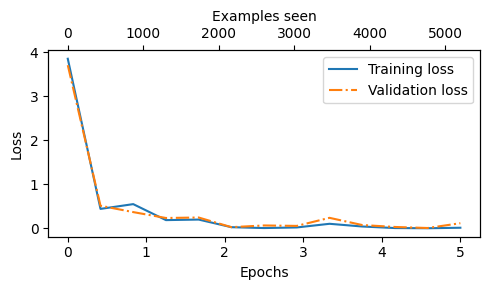

In [2]:
import matplotlib.pyplot as plt
def plot_values(
        epochs_seen, examples_seen, train_values, val_values,
        label="loss"
    ):
    fig, ax1 = plt.subplots(figsize=(5, 3))
    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(
        epochs_seen, val_values, linestyle="-.",
        label=f"Validation {label}"
    )
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    ax2 = ax1.twiny()
    ax2.plot(examples_seen, train_values, alpha=0)
    ax2.set_xlabel("Examples seen")
    fig.tight_layout()
    plt.savefig(f"{label}-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))
plot_values(
    epochs_tensor, examples_seen_tensor,
    train_losses, val_losses, label="loss"
)

In [4]:
train_accuracy = calc_accuracy_loader(train_loader, gpt, device)
val_accuracy = calc_accuracy_loader(val_loader, gpt, device)
test_accuracy = calc_accuracy_loader(test_loader, gpt, device)
print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 98.85%
Validation accuracy: 94.63%
Test accuracy: 96.67%


In [5]:
from utils.ClassifyReview import classify_review

text_1 = (
    "You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award."
)
print(classify_review(
    text_1, gpt, tokenizer, device, max_length=train_dataset.max_length
))

text_2 = (
    "Hey, just wanted to check if we're still on"
    " for dinner tonight? Let me know!"
)
print(classify_review(
    text_2, gpt, tokenizer, device, max_length=train_dataset.max_length
))

spam
not spam


In [6]:
torch.save(gpt.state_dict(), "review_classifier_loRA.pth")